# Word2Vec Scratch

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from collections import defaultdict
import multiprocessing

import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from preprocessing_funcs import clean_tweet, get_hashtags, hashtag_dict

TEST

In [2]:
documents = ["Will this work?  I'm not sure.  If not go to step #4 (above)"]
texts = [[word for word in document.lower().split()]
         for document in documents]


print (texts)
model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1, workers=2,sg=1)

[['will', 'this', 'work?', "i'm", 'not', 'sure.', 'if', 'not', 'go', 'to', 'step', '#4', '(above)']]


## Data Import

In [3]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [4]:
df = df[['text']]

In [5]:
df['clean'] = df['text'].map(clean_tweet)

In [6]:
df['clean'] = df['clean'].replace(hashtag_dict, regex=True)

In [7]:
df.head()

,text,clean
0,#IslamKills Are you trying to say that there w...,islam kills are you trying to say that there w...
1,"Clinton: Trump should’ve apologized more, atta...",clinton trump should ve apologized more attack...
2,RT @ltapoll: Who was/is the best president of ...,who was is the best president of the past year...
3,RT @jww372: I don't have to guess your religio...,i don t have to guess your religion christmas ...
4,RT @Shareblue: Pence and his lawyers decided w...,pence and his lawyers decided which of his off...


# Modeling

Following the steps laid out in this [SUPER GREAT TUTORIAL](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial)

In [8]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## Hunting for bigrams

In [9]:
sent = [row.split() for row in df['clean']]

In [10]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 13:13:43: collecting all words and their counts
INFO - 13:13:43: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:13:43: PROGRESS: at sentence #10000, processed 125854 words and 92738 word types
INFO - 13:13:43: PROGRESS: at sentence #20000, processed 253042 words and 160684 word types
INFO - 13:13:43: PROGRESS: at sentence #30000, processed 379516 words and 219086 word types
INFO - 13:13:44: PROGRESS: at sentence #40000, processed 504792 words and 271416 word types
INFO - 13:13:44: PROGRESS: at sentence #50000, processed 629732 words and 319767 word types
INFO - 13:13:44: PROGRESS: at sentence #60000, processed 756218 words and 365016 word types
INFO - 13:13:44: PROGRESS: at sentence #70000, processed 882194 words and 408066 word types
INFO - 13:13:44: PROGRESS: at sentence #80000, processed 1008659 words and 449588 word types
INFO - 13:13:45: PROGRESS: at sentence #90000, processed 1134222 words and 488703 word types
INFO - 13:13:45: PROGRESS: at sentence

In [11]:
bigram = Phraser(phrases)

INFO - 13:13:50: source_vocab length 850842
INFO - 13:13:55: Phraser built with 1021 phrasegrams


In [12]:
sentences = bigram[sent]

## Most frequent words

In [13]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

92618

In [14]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['the', 'to', 'a', 'in', 'trump', 's', 'of', 'is', 'and', 'for']

## Training the model

### Initialize Model

In [15]:
cores = multiprocessing.cpu_count()
cores

12

In [16]:
w2v_model = Word2Vec(min_count=20,
                     window=3,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

### Build Vocabulary

In [17]:
from time import time 

In [18]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:14:35: collecting all words and their counts
INFO - 13:14:35: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:14:35: PROGRESS: at sentence #10000, processed 117070 words, keeping 18639 word types
INFO - 13:14:36: PROGRESS: at sentence #20000, processed 235551 words, keeping 27561 word types
INFO - 13:14:36: PROGRESS: at sentence #30000, processed 353109 words, keeping 34408 word types
INFO - 13:14:36: PROGRESS: at sentence #40000, processed 469683 words, keeping 40044 word types
INFO - 13:14:36: PROGRESS: at sentence #50000, processed 586002 words, keeping 45118 word types
INFO - 13:14:37: PROGRESS: at sentence #60000, processed 703557 words, keeping 49630 word types
INFO - 13:14:37: PROGRESS: at sentence #70000, processed 820565 words, keeping 53835 word types
INFO - 13:14:37: PROGRESS: at sentence #80000, processed 938221 words, keeping 57769 word types
INFO - 13:14:37: PROGRESS: at sentence #90000, processed 1054993 words, keeping 61424 word typ

Time to build vocab: 0.12 mins


### Training of the Model

In [19]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:15:01: training model with 11 workers on 9710 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3
INFO - 13:15:02: EPOCH 1 - PROGRESS: at 15.02% examples, 161793 words/s, in_qsize 0, out_qsize 0
INFO - 13:15:03: EPOCH 1 - PROGRESS: at 26.38% examples, 141668 words/s, in_qsize 0, out_qsize 0
INFO - 13:15:04: EPOCH 1 - PROGRESS: at 42.30% examples, 151635 words/s, in_qsize 0, out_qsize 0
INFO - 13:15:05: EPOCH 1 - PROGRESS: at 58.22% examples, 156447 words/s, in_qsize 0, out_qsize 0
INFO - 13:15:06: EPOCH 1 - PROGRESS: at 74.15% examples, 158910 words/s, in_qsize 0, out_qsize 0
INFO - 13:15:07: EPOCH 1 - PROGRESS: at 86.30% examples, 152455 words/s, in_qsize 0, out_qsize 0
INFO - 13:15:08: worker thread finished; awaiting finish of 10 more threads
INFO - 13:15:08: worker thread finished; awaiting finish of 9 more threads
INFO - 13:15:08: worker thread finished; awaiting finish of 8 more threads
INFO - 13:15:08: worker thread finished; awaiting finish 

INFO - 13:15:42: EPOCH 6 - PROGRESS: at 82.54% examples, 146732 words/s, in_qsize 0, out_qsize 0
INFO - 13:15:43: EPOCH 6 - PROGRESS: at 97.57% examples, 148533 words/s, in_qsize 0, out_qsize 0
INFO - 13:15:43: worker thread finished; awaiting finish of 10 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 9 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 8 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 7 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 6 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 5 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 4 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 3 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 2 more threads
INFO - 13:15:43: worker thread finished; awaiting finish of 1 more threads
INFO - 13:15:43: worker thread finished; awaiting finis

INFO - 13:16:18: worker thread finished; awaiting finish of 8 more threads
INFO - 13:16:18: worker thread finished; awaiting finish of 7 more threads
INFO - 13:16:18: worker thread finished; awaiting finish of 6 more threads
INFO - 13:16:18: worker thread finished; awaiting finish of 5 more threads
INFO - 13:16:18: worker thread finished; awaiting finish of 4 more threads
INFO - 13:16:18: worker thread finished; awaiting finish of 3 more threads
INFO - 13:16:18: worker thread finished; awaiting finish of 2 more threads
INFO - 13:16:18: EPOCH 11 - PROGRESS: at 99.66% examples, 152533 words/s, in_qsize 1, out_qsize 1
INFO - 13:16:18: worker thread finished; awaiting finish of 1 more threads
INFO - 13:16:18: worker thread finished; awaiting finish of 0 more threads
INFO - 13:16:18: EPOCH - 11 : training on 2386503 raw words (1083564 effective words) took 7.1s, 152817 effective words/s
INFO - 13:16:19: EPOCH 12 - PROGRESS: at 14.18% examples, 152955 words/s, in_qsize 0, out_qsize 0
INFO - 

INFO - 13:16:54: worker thread finished; awaiting finish of 6 more threads
INFO - 13:16:54: worker thread finished; awaiting finish of 5 more threads
INFO - 13:16:54: worker thread finished; awaiting finish of 4 more threads
INFO - 13:16:54: worker thread finished; awaiting finish of 3 more threads
INFO - 13:16:54: worker thread finished; awaiting finish of 2 more threads
INFO - 13:16:54: worker thread finished; awaiting finish of 1 more threads
INFO - 13:16:54: worker thread finished; awaiting finish of 0 more threads
INFO - 13:16:54: EPOCH - 16 : training on 2386503 raw words (1084145 effective words) took 7.5s, 145002 effective words/s
INFO - 13:16:55: EPOCH 17 - PROGRESS: at 12.10% examples, 128801 words/s, in_qsize 0, out_qsize 0
INFO - 13:16:56: EPOCH 17 - PROGRESS: at 23.86% examples, 126963 words/s, in_qsize 0, out_qsize 0
INFO - 13:16:57: EPOCH 17 - PROGRESS: at 39.78% examples, 141023 words/s, in_qsize 0, out_qsize 0
INFO - 13:16:58: EPOCH 17 - PROGRESS: at 55.72% examples, 1

INFO - 13:17:29: worker thread finished; awaiting finish of 1 more threads
INFO - 13:17:29: worker thread finished; awaiting finish of 0 more threads
INFO - 13:17:29: EPOCH - 21 : training on 2386503 raw words (1083703 effective words) took 6.6s, 163865 effective words/s
INFO - 13:17:30: EPOCH 22 - PROGRESS: at 11.68% examples, 126630 words/s, in_qsize 0, out_qsize 0
INFO - 13:17:31: EPOCH 22 - PROGRESS: at 27.22% examples, 147097 words/s, in_qsize 0, out_qsize 0
INFO - 13:17:32: EPOCH 22 - PROGRESS: at 43.57% examples, 155652 words/s, in_qsize 0, out_qsize 0
INFO - 13:17:33: EPOCH 22 - PROGRESS: at 59.06% examples, 158044 words/s, in_qsize 0, out_qsize 0
INFO - 13:17:34: EPOCH 22 - PROGRESS: at 70.39% examples, 149899 words/s, in_qsize 0, out_qsize 0
INFO - 13:17:35: EPOCH 22 - PROGRESS: at 85.46% examples, 152038 words/s, in_qsize 0, out_qsize 0
INFO - 13:17:36: worker thread finished; awaiting finish of 10 more threads
INFO - 13:17:36: worker thread finished; awaiting finish of 9 mo

INFO - 13:18:06: EPOCH - 26 : training on 2386503 raw words (1084018 effective words) took 7.2s, 150894 effective words/s
INFO - 13:18:07: EPOCH 27 - PROGRESS: at 11.68% examples, 124704 words/s, in_qsize 0, out_qsize 0
INFO - 13:18:08: EPOCH 27 - PROGRESS: at 26.79% examples, 143708 words/s, in_qsize 0, out_qsize 0
INFO - 13:18:09: EPOCH 27 - PROGRESS: at 41.46% examples, 147148 words/s, in_qsize 0, out_qsize 0
INFO - 13:18:10: EPOCH 27 - PROGRESS: at 54.04% examples, 143578 words/s, in_qsize 0, out_qsize 0
INFO - 13:18:11: EPOCH 27 - PROGRESS: at 64.93% examples, 138362 words/s, in_qsize 0, out_qsize 0
INFO - 13:18:12: EPOCH 27 - PROGRESS: at 79.61% examples, 141574 words/s, in_qsize 0, out_qsize 0
INFO - 13:18:13: EPOCH 27 - PROGRESS: at 95.48% examples, 145522 words/s, in_qsize 0, out_qsize 0
INFO - 13:18:13: worker thread finished; awaiting finish of 10 more threads
INFO - 13:18:13: worker thread finished; awaiting finish of 9 more threads
INFO - 13:18:13: worker thread finished; 

Time to train the model: 3.56 mins


## Using the model

In [20]:
w2v_model.wv.most_similar(positive=["trump"], topn=15)

INFO - 13:18:47: precomputing L2-norms of word weight vectors


[('donald_trump', 0.6655164957046509),
 ('clinton', 0.5325742959976196),
 ('real_donald', 0.5214942097663879),
 ('hillary', 0.5097488164901733),
 ('hillary_clinton', 0.455899178981781),
 ('he', 0.4222342371940613),
 ('obama', 0.4196580946445465),
 ('politics', 0.41645944118499756),
 ('priebus', 0.41381335258483887),
 ('rigged_election', 0.4039263427257538),
 ('pence', 0.4011918902397156),
 ('politics_extra', 0.3986321985721588),
 ('christie', 0.39420053362846375),
 ('gop', 0.3937153220176697),
 ('media', 0.38052332401275635)]

In [21]:
w2v_model.wv.most_similar(positive=["clinton"], topn=15)

[('hillary_clinton', 0.671727180480957),
 ('hillary', 0.6416050791740417),
 ('trump', 0.5325742363929749),
 ('politics', 0.512069046497345),
 ('politics_extra', 0.46823370456695557),
 ('clinton_camp', 0.45932072401046753),
 ('donald_trump', 0.44799232482910156),
 ('crooked_hillary', 0.4421145021915436),
 ('sanders', 0.429745614528656),
 ('leaked_email', 0.4216647148132324),
 ('dnc', 0.41480571031570435),
 ('emails_show', 0.41267964243888855),
 ('donna_brazile', 0.4122263491153717),
 ('guccifer', 0.40862154960632324),
 ('huma_abedin', 0.4042300581932068)]

In [22]:
w2v_model.wv.doesnt_match(['trump', 'clinton', 'isis'])

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'isis'

In [23]:
w2v_model.wv.most_similar(positive=["man", "clinton"], negative=["trump"], topn=3)

[('woman', 0.4059233069419861),
 ('unarmed', 0.3466968536376953),
 ('elderly', 0.31941813230514526)]

In [24]:
w2v_model.wv.most_similar(positive=["woman", "obama"], negative=["man"], topn=3)

[('hillary', 0.36142805218696594),
 ('clinton', 0.3414429724216461),
 ('trump', 0.3399924635887146)]

## Visualizations

In [28]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')  # This relates to the size parameter of the model tuning
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 19 dimensions with PCA 
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

### 10 Most Similar Words vs. 8 Random Words

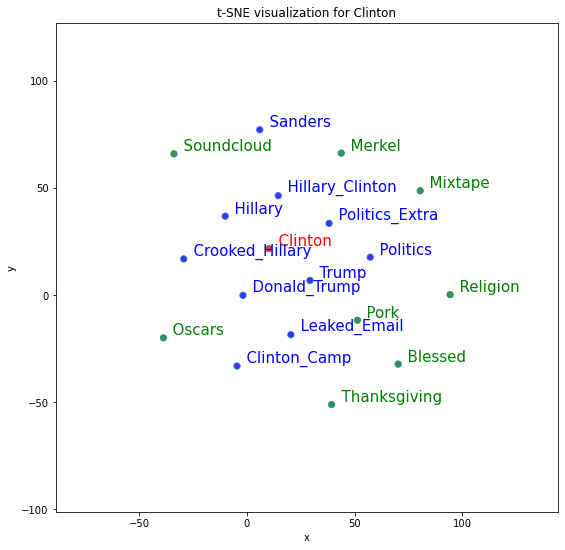

In [29]:
tsnescatterplot(w2v_model, 'clinton', ['soundcloud', 'mixtape', 'merkel', 'blessed', 
                                       'pork', 'thanksgiving', 'oscars', 'religion'])

### 10 Most Similar Words vs. 10 Most Dissimilar

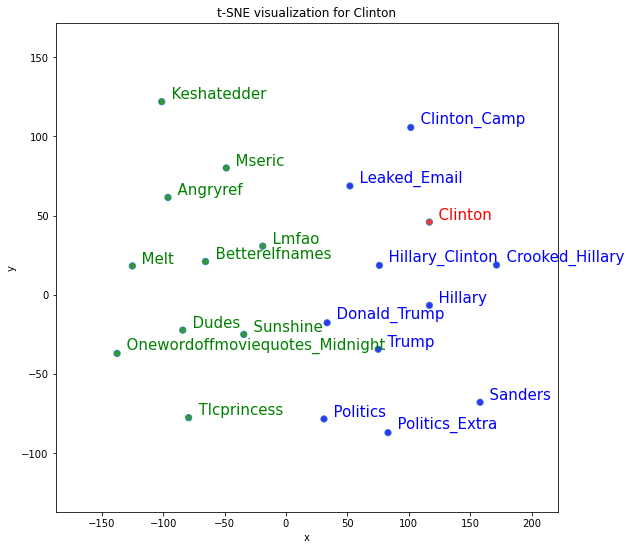

In [30]:
tsnescatterplot(w2v_model, 'clinton', [i[0] for i in w2v_model.wv.most_similar(negative=["clinton"])])

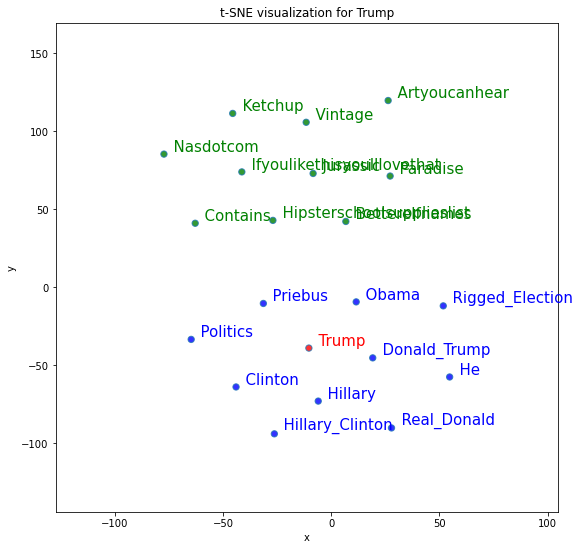

In [31]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(negative=["trump"])])

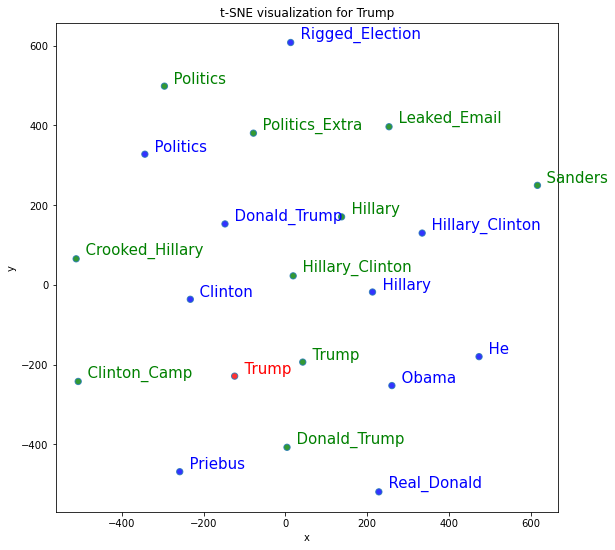

In [32]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(positive=["clinton"])])

### 10 Most similar words vs. 11th to 20th Most similar words

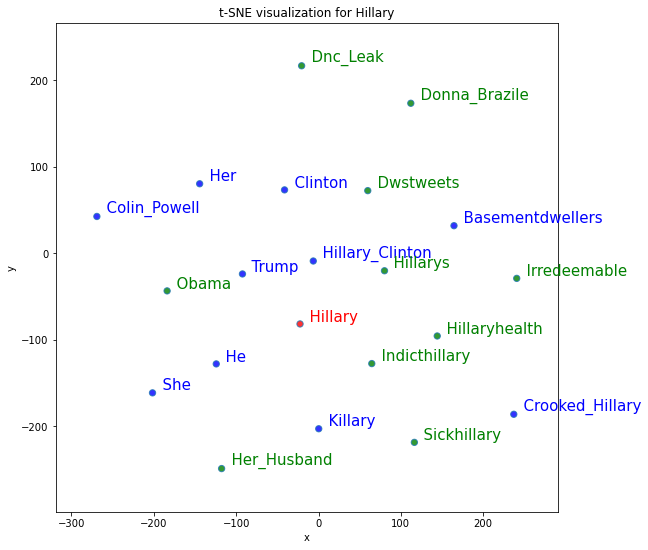

In [33]:
tsnescatterplot(w2v_model, "hillary", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["hillary"], topn=20)][10:])

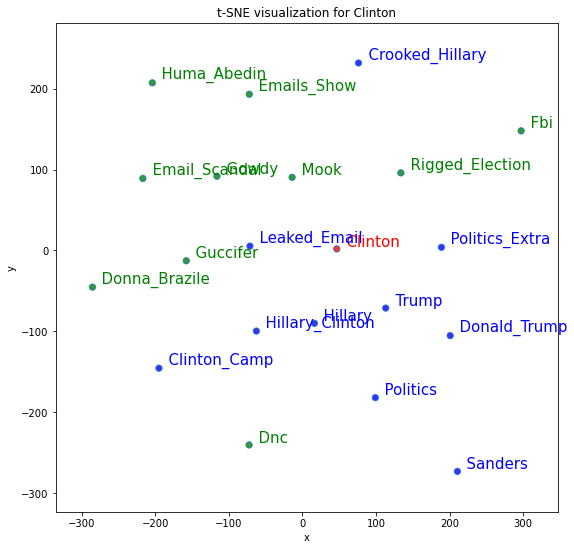

In [34]:
tsnescatterplot(w2v_model, "clinton", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["clinton"], topn=20)][10:])

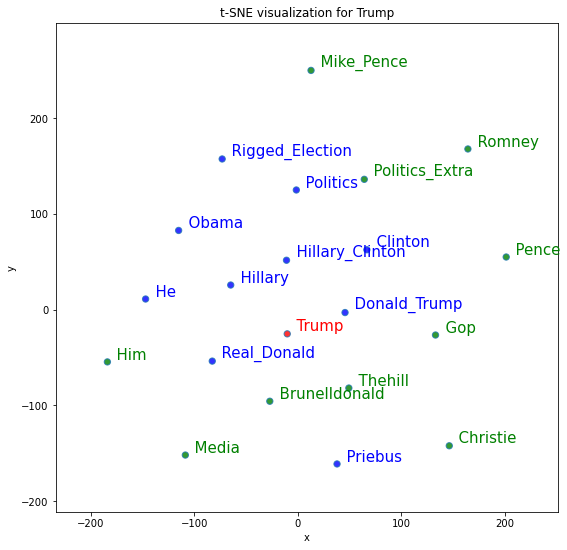

In [35]:
tsnescatterplot(w2v_model, "trump", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["trump"], topn=20)][10:])

### Scatterplot of Shared Terms: Trump & Clinton

In [144]:
num_words = 25

clinton_words = [word[0] for word in w2v_model.wv.most_similar(positive=["clinton"], topn=num_words)]
clinton_words_clinton_scores = [score[1] for score in w2v_model.wv.most_similar(positive=["clinton"], topn=num_words)]
w2v_model.wv.most_similar(positive=["clinton"], topn=num_words)

[('hillary_clinton', 0.671727180480957),
 ('hillary', 0.6416050791740417),
 ('trump', 0.5325742363929749),
 ('politics', 0.512069046497345),
 ('politics_extra', 0.46823370456695557),
 ('clinton_camp', 0.45932072401046753),
 ('donald_trump', 0.44799232482910156),
 ('crooked_hillary', 0.4421145021915436),
 ('sanders', 0.429745614528656),
 ('leaked_email', 0.4216647148132324),
 ('dnc', 0.41480571031570435),
 ('emails_show', 0.41267964243888855),
 ('donna_brazile', 0.4122263491153717),
 ('guccifer', 0.40862154960632324),
 ('huma_abedin', 0.4042300581932068),
 ('fbi', 0.40245336294174194),
 ('rigged_election', 0.40152105689048767),
 ('mook', 0.40109914541244507),
 ('gowdy', 0.39328816533088684),
 ('email_scandal', 0.3925060033798218),
 ('colin_powell', 0.3916168212890625),
 ('her', 0.3883817791938782),
 ('campaign', 0.3872339427471161),
 ('podesta', 0.38720324635505676),
 ('wikileaks', 0.38701534271240234)]

In [169]:
words_to_exclude = ['hillary_clinton','clinton', 'hillary','trump','donald_trump', 
                    'real_donald', 'him', 'he', 'her', 'trumps']

num_words = 25

clinton_words = [word[0] for word in w2v_model.wv.most_similar(positive=["clinton"], topn=num_words) 
                 if word[0] not in words_to_exclude]

print(len(clinton_words))
print(clinton_words)

20
['politics', 'politics_extra', 'clinton_camp', 'crooked_hillary', 'sanders', 'leaked_email', 'dnc', 'emails_show', 'donna_brazile', 'guccifer', 'huma_abedin', 'fbi', 'rigged_election', 'mook', 'gowdy', 'email_scandal', 'colin_powell', 'campaign', 'podesta', 'wikileaks']


In [170]:
clinton_words_clinton_scores = [w2v_model.wv.similarity("clinton", word) for word in clinton_words]

In [172]:
num_words = 28

trump_words = [word[0] for word in w2v_model.wv.most_similar(positive=["trump"], topn=num_words) 
                 if word[0] not in words_to_exclude]

print(len(trump_words))
print(trump_words)

20
['obama', 'politics', 'priebus', 'rigged_election', 'pence', 'politics_extra', 'christie', 'gop', 'media', 'mike_pence', 'romney', 'brunelldonald', 'thehill', 'crooked_hillary', 'peotus', 'genflynn', 'alwaystrump', 'jill_stein', 'evan_mcmullin', 'jeb']


In [173]:
trump_words_trump_scores = [w2v_model.wv.similarity("trump", word) for word in trump_words]

In [174]:
trump_words_trump_scores

[0.41965812,
 0.41645947,
 0.41381338,
 0.40392634,
 0.40119186,
 0.39863217,
 0.3942005,
 0.39371535,
 0.3805233,
 0.3797394,
 0.377528,
 0.369599,
 0.36629894,
 0.36593896,
 0.35490578,
 0.35030866,
 0.34975705,
 0.34928927,
 0.34673798,
 0.34250835]

In [177]:
clinton_words_trump_scores = []

print('Word Similaritiy between "Trump" and words most associated with "Clinton"')
print('---------------------------')
for word in clinton_words:
    print("%-20s %4.4f" % (word, w2v_model.wv.similarity("trump", word)))
    clinton_words_trump_scores.append(w2v_model.wv.similarity("trump", word))

Word Similaritiy between "Trump" and words most associated with "Clinton"
---------------------------
politics             0.4165
politics_extra       0.3986
clinton_camp         0.2608
crooked_hillary      0.3659
sanders              0.2948
leaked_email         0.1675
dnc                  0.2145
emails_show          0.1491
donna_brazile        0.2281
guccifer             0.1108
huma_abedin          0.0812
fbi                  0.1546
rigged_election      0.4039
mook                 0.2607
gowdy                0.0786
email_scandal        0.2006
colin_powell         0.2560
campaign             0.3076
podesta              0.0757
wikileaks            0.2608


In [181]:
trump_words_clinton_scores = []

print('Word Similaritiy between "Clinton" and words most associated with "Trump"')
print('---------------------------')
for word in trump_words:
    print("%-20s %4.4f" % (word, w2v_model.wv.similarity("clinton", word)))
    trump_words_clinton_scores.append(w2v_model.wv.similarity("clinton", word))

Word Similaritiy between "Clinton" and words most associated with "Trump"
---------------------------
obama                0.3607
politics             0.5121
priebus              0.3206
rigged_election      0.4015
pence                0.2754
politics_extra       0.4682
christie             0.3869
gop                  0.3539
media                0.2886
mike_pence           0.1818
romney               0.3135
brunelldonald        0.1782
thehill              0.1802
crooked_hillary      0.4421
peotus               0.0673
genflynn             0.2127
alwaystrump          0.1023
jill_stein           0.3344
evan_mcmullin        0.1250
jeb                  0.2924


In [187]:
shared_words = [word for word in trump_words if word in clinton_words]
shared_words

['politics', 'rigged_election', 'politics_extra', 'crooked_hillary']

In [191]:
only_clinton_words = [word for word in clinton_words if word not in shared_words]
only_trump_words = [word for word in trump_words if word not in shared_words]

In [208]:
shared_score_clinton = []
shared_score_trump = []

print('Word Similiarity Scores for Shared Words')
print('-----------------------------------')
print('Topic               Clinton   Trump')
print('-----------------------------------')
for word in shared_words:
    clinton_score = w2v_model.wv.similarity("clinton", word)
    trump_score = w2v_model.wv.similarity("trump", word)
    print("%-20s %4.4f  %4.4f" % (word, clinton_score, trump_score))
    shared_score_clinton.append(clinton_score)
    shared_score_trump.append(trump_score)

Word Similiarity Scores for Shared Words
-----------------------------------
Topic               Clinton   Trump
-----------------------------------
politics             0.5121  0.4165
rigged_election      0.4015  0.4039
politics_extra       0.4682  0.3986
crooked_hillary      0.4421  0.3659


In [222]:
trump_words_clinton_scores = [w2v_model.wv.similarity("clinton", word) for word in only_trump_words]
trump_words_trump_scores = [w2v_model.wv.similarity("trump", word) for word in only_trump_words]

clinton_words_clinton_scores = [w2v_model.wv.similarity("clinton", word) for word in only_clinton_words]
clinton_words_trump_scores = [w2v_model.wv.similarity("trump", word) for word in only_clinton_words]

In [318]:
def annotate_points(x, y, label):
    for i, txt in enumerate(label):
        plt.annotate(txt,
                     xy=(x[i], y[i]),
                     xytext=(6, 7), textcoords='offset points',
                     fontsize=12)

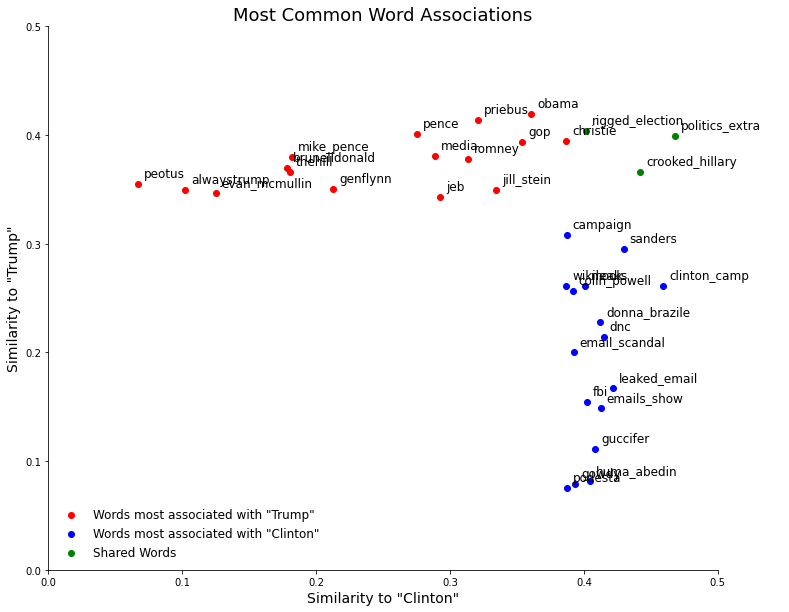

In [319]:
plt.figure(figsize=(12,10))

plt.scatter(trump_words_clinton_scores, trump_words_trump_scores, color='r', 
            label='Words most associated with "Trump"')

plt.scatter(clinton_words_clinton_scores, clinton_words_trump_scores, color='b', 
            label='Words most associated with "Clinton"')

plt.scatter(shared_score_clinton, shared_score_trump, color='g', label='Shared Words')

annotate_points(trump_words_clinton_scores, trump_words_trump_scores, only_trump_words)
annotate_points(clinton_words_clinton_scores, clinton_words_trump_scores, only_clinton_words)
annotate_points(shared_score_clinton, shared_score_trump, shared_words)

plt.xlabel('Similarity to "Clinton"', fontsize=14)
plt.ylabel('Similarity to "Trump"',fontsize=14)
plt.title('Most Common Word Associations', fontsize=18)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.legend(loc='lower left', frameon=False, fontsize=12)
sns.despine()

## Saving the model

No more training - using `init_sims()` to make the model more memory efficient

In [136]:
w2v_model.init_sims(replace=True)

INFO - 14:47:55: precomputing L2-norms of word weight vectors


In [137]:
w2v_model.save("w2v.model")

INFO - 14:47:59: saving Word2Vec object under w2v.model, separately None
INFO - 14:47:59: not storing attribute vectors_norm
INFO - 14:47:59: not storing attribute cum_table
INFO - 14:47:59: saved w2v.model


In [139]:
# to load
# model = gensim.models.Word2Vec.load("w2v.model")

INFO - 14:48:06: loading Word2Vec object from w2v.model
INFO - 14:48:07: loading wv recursively from w2v.model.wv.* with mmap=None
INFO - 14:48:07: setting ignored attribute vectors_norm to None
INFO - 14:48:07: loading vocabulary recursively from w2v.model.vocabulary.* with mmap=None
INFO - 14:48:07: loading trainables recursively from w2v.model.trainables.* with mmap=None
INFO - 14:48:07: setting ignored attribute cum_table to None
INFO - 14:48:07: loaded w2v.model
